# Neural Network Model Development with Fixed Architecture

## Import Libraries

In [1]:
# records and calculations
import pandas as pd
import numpy as np

# visualizations
import matplotlib.pyplot as plt
import seaborn as sns

# core ML
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score, average_precision_score, classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc, accuracy_score, f1_score, precision_score, recall_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# neural network tools
import tensorflow as tf
tf.get_logger().setLevel('ERROR')

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from scikeras.wrappers import KerasClassifier
tf.random.set_seed(42)

# Persistence
import joblib
import pickle

# avoid minor warnings
import warnings
warnings.filterwarnings('ignore')

# read file path
from pathlib import Path

## Load Dataset and Saved Artifacts

In [2]:
""" File and Artifacts Directories """

# dataset path
file = Path(r"../data/CleanedLoanData.csv")

# artifacts path
artifacts_dir = Path(r"../artifacts/feature-selection")

# model performance path
model_performance_dir = Path(r"../artifacts/model-performance")

# models path
model_dir = Path(r"../artifacts/models")


In [3]:
# laod dataset
df = pd.read_csv(file)

In [4]:
# feature-target separation
x = df.drop(columns=['LoanStatus'])
y = df['LoanStatus']

In [5]:
# load artifacts
x_train = joblib.load(artifacts_dir / "x_train.pkl")
x_train_scale = joblib.load(artifacts_dir / "x_train_scaler.pkl")
x_test = joblib.load(artifacts_dir / "x_test.pkl")
x_test_scale = joblib.load(artifacts_dir / "x_test_scaler.pkl")
y_train = joblib.load(artifacts_dir / "y_train.pkl")
y_test = joblib.load(artifacts_dir / "y_test.pkl")

cv = joblib.load(artifacts_dir / "cv.pkl")

# configure socring metrics
scoring_metrics = 'roc_auc'

In [6]:
# load performance metrics
cross_val_df = pd.read_csv(model_performance_dir / "a_CrossValidationScore.csv")                # cross-validation scores
model_perf_df = pd.read_csv(model_performance_dir / "a_ModelsPerformance.csv")                  # all models performance
model_score_df = pd.read_csv(model_performance_dir / "a_ModelsScores.csv")                      # all models ranking
overfit_df = pd.read_csv(model_performance_dir / "a_OverfittingAnalysis.csv")                   # all models overfitting analysis

## Model Training with Fixed Architecture Optimization

In [7]:
# creates and compile a simple feedforward neural network for binary classification
def nn_model(input_dim):
    model = Sequential([
        Dense(64, activation='relu', input_shape=(input_dim,)),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['AUC'], jit_compile=True)
    return model

In [8]:
def build_nn_model():
    return nn_model(x_train_scale.shape[1])

In [9]:
# early stopping callback
callback = [EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)]

# wrapper for NN model
nn = KerasClassifier(
    model=build_nn_model,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=callback,
    verbose=0,
    random_state=42
)

In [10]:
# train and identify the best parameter
nn.fit(x_train_scale, y_train)

best_model = nn

## Apply Model to Make Prediction and Get Probabilities

In [11]:
# get predicted probabilities
train_proba = best_model.predict_proba(x_train_scale)[:, 1]
test_proba = best_model.predict_proba(x_test_scale)[:, 1]

In [12]:
# make prediction on training and test set
train_pred = (train_proba > 0.5).astype(int)
test_pred = (test_proba > 0.5).astype(int)

## Evaluating Model Performance

In [13]:
# Training Metrics
train_auc_roc = roc_auc_score(y_train, train_proba)             # ROC-AUC score
train_auc_pr = average_precision_score(y_train, train_proba)    # average precision
train_acc = accuracy_score(y_train, train_pred)                 # accuracy score
train_precision = precision_score(y_train, train_pred)          # precision score
train_recall = recall_score(y_train, train_pred)                # recall score
train_f1 = f1_score(y_train, train_pred)                        # f1 score

In [14]:
# Test Metrics
test_auc_roc = roc_auc_score(y_test, test_proba)             # ROC-AUC score
test_auc_pr = average_precision_score(y_test, test_proba)    # average precision
test_acc = accuracy_score(y_test, test_pred)                 # accuracy score
test_precision = precision_score(y_test, test_pred)          # precision score
test_recall = recall_score(y_test, test_pred)                # recall score
test_f1 = f1_score(y_test, test_pred)                        # f1 score

### Performance Report for Training and Test Set

In [15]:
# classification report for train set
print("=== Performance on Training Set ===".center(55, '='))
train_report = classification_report(y_train, train_pred)
print(train_report)


============= Performance on Training Set =============
              precision    recall  f1-score   support

           0       0.91      0.44      0.59       153
           1       0.79      0.98      0.88       335

    accuracy                           0.81       488
   macro avg       0.85      0.71      0.73       488
weighted avg       0.83      0.81      0.79       488



In [16]:
# classification report for test set
print("=== Performance on Test Set ===".center(55, '='))
test_report = classification_report(y_test, test_pred)
print(test_report)

=============== Performance on Test Set ===============
              precision    recall  f1-score   support

           0       0.96      0.64      0.77        39
           1       0.86      0.99      0.92        84

    accuracy                           0.88       123
   macro avg       0.91      0.81      0.84       123
weighted avg       0.89      0.88      0.87       123



### Performance Metrics

In [17]:
# model status & gap generalization
model_status = 'Good' if test_acc > 0.85 else 'Fair' if test_acc > 0.75 else 'Needs Improvement'
generalization = 'Overfitting' if train_acc - test_acc > 0.05 else 'Best Fit'

# performance table
performance_df = pd.DataFrame({
    'Metric': [
        'AUC-ROC',
        'AUC-PR',
        'Precision',
        'Recall',
        'F1-Score',
        'Accuracy',
        'Generalization',
        'Model Status'
    ],
    'Training': [
        f"{train_auc_roc:.3f}",
        f"{train_auc_pr:.3f}",
        f"{train_precision:.3f}",
        f"{train_recall:.3f}",
        f"{train_f1:.3f}",
        f"{train_acc:.3f}",
        '-',
        '-'
    ],
    'Test': [
        f"{test_auc_roc:.3f}",
        f"{test_auc_pr:.3f}",
        f"{test_precision:.3f}",
        f"{test_recall:.3f}",
        f"{test_f1:.3f}",
        f"{test_acc:.3f}",
        '-',
        model_status
    ],
    'Gap/Generalization': [
        f"{abs(train_auc_roc - test_auc_roc):.3f}",
        f"{abs(train_auc_pr - test_auc_pr):.3f}",
        f"{abs(train_precision - test_precision):.3f}",
        f"{abs(train_recall - test_recall):.3f}",
        f"{abs(train_f1 - test_f1):.3f}",
        f"{abs(train_acc - test_acc):.3f}",
        generalization,
        '-'
    ]
})

In [18]:
# performance table
print("=== Neural Network Performance Metrics ===".center(52, '='))
performance_df

======== Neural Network Performance Metrics ========


,Metric,Training,Test,Gap/Generalization
0,AUC-ROC,0.811,0.845,0.033
1,AUC-PR,0.870,0.884,0.014
2,Precision,0.792,0.856,0.063
3,Recall,0.979,0.988,0.009
4,F1-Score,0.876,0.917,0.041
5,Accuracy,0.809,0.878,0.069
6,Generalization,-,-,Best Fit
7,Model Status,-,Good,-


In [19]:
print("=== Metrics Summary ===")
print(f"Training Accuracy: {train_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Accuracy Gap: {abs(train_acc - test_acc):.4f} ({generalization})")
print(f"Model Performance: {model_status}")

=== Metrics Summary ===
Training Accuracy: 0.8094
Test Accuracy: 0.8780
Accuracy Gap: 0.0686 (Best Fit)
Model Performance: Good


## ROC-Curve

In [20]:
# roc curve for training and testing set
train_fpr, train_tpr, _ = roc_curve(y_train, train_proba)
test_fpr, test_tpr, _ = roc_curve(y_test, test_proba)

In [21]:
# calculate AUC for training and testing set
train_auc = auc(train_fpr, train_tpr)
test_auc = auc(test_fpr, test_tpr)

**NOTE:** We can use training and test AUC-ROC (`roc_auc_score`) values to plot ROC curves

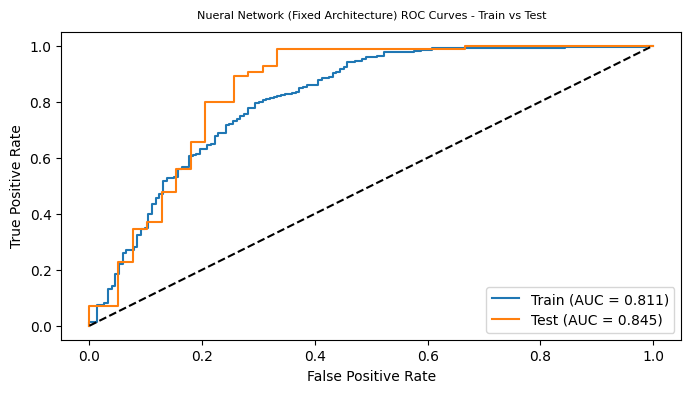

In [22]:
# figure size
plt.figure(figsize=(8, 4))

# ploting the curve
plt.plot(train_fpr, train_tpr, label=f'Train (AUC = {train_auc:.3f})')
plt.plot(test_fpr, test_tpr, label=f'Test (AUC = {test_auc:.3f})')
plt.plot([0, 1], [0, 1], 'k--')

# set labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Nueral Network (Fixed Architecture) ROC Curves - Train vs Test',  y=1.02, fontsize=8)
plt.legend()
plt.show()

## Confusion Matrix

In [23]:
# confusion matrix for training and test set
train_cnf = confusion_matrix(y_train, train_pred)
test_cnf = confusion_matrix(y_test, test_pred)

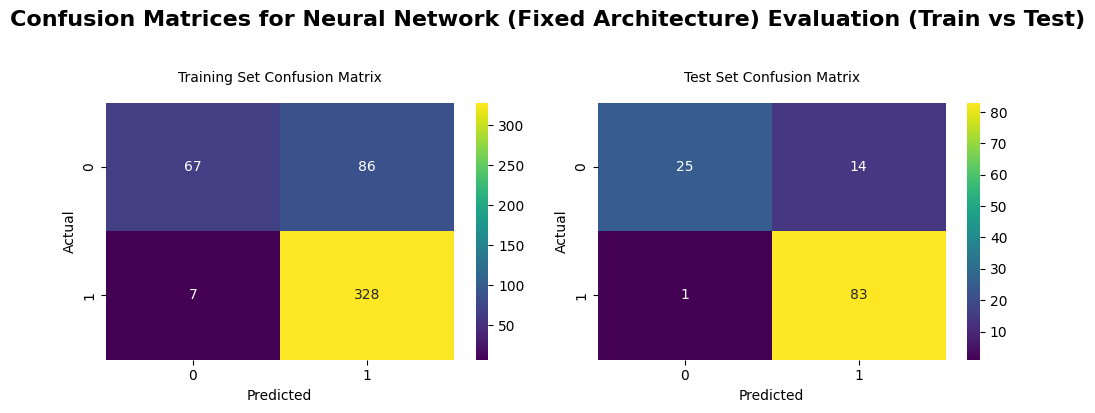

In [24]:
""" visualize confusion matrices """
# number of subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes = axes.flatten()

# confusion matrix for training set
ax = axes[0]
sns.heatmap(train_cnf, annot=True, fmt='d', cmap='viridis', ax=ax)

# set labels
ax.set_title("Training Set Confusion Matrix", fontsize=10, y=1.05)
ax.set_xlabel("Predicted")
ax.set_ylabel("Actual")


# confusion matrix for test set
ax = axes[1]
sns.heatmap(test_cnf, annot=True, fmt='d', cmap='viridis', ax=ax)

# set labels
ax.set_title("Test Set Confusion Matrix", fontsize=10, y=1.05)
ax.set_xlabel("Predicted")
ax.set_ylabel("Actual")

# ========== Layout ==========
plt.suptitle(f"Confusion Matrices for Neural Network (Fixed Architecture) Evaluation (Train vs Test)", y=1.02, fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

## Cross-Validation Scores

In [25]:
# cross validation evaluation
cv_scores = []

# calucate cross-validation scores
for train_idx, test_idx in cv.split(x, y):
    x_train_fold, x_test_fold = x.iloc[train_idx], x.iloc[test_idx]
    y_train_fold, y_test_fold = y.iloc[train_idx], y.iloc[test_idx]

    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', KerasClassifier(
            model=lambda: nn_model(x.shape[1]),
            epochs=100,
            batch_size=32,
            validation_split=0.2,
            callbacks=callback,
            verbose=0,
            random_state=42
        ))
    ])

    pipeline.fit(x_train_fold, y_train_fold)
    y_proba = pipeline.predict_proba(x_test_fold)[:, 1]
    fold_score = roc_auc_score(y_test_fold, y_proba)
    cv_scores.append(fold_score)


In [26]:
# CV score mean and std
cv_scores = np.array(cv_scores)
cv_mean = cv_scores.mean()
cv_std = cv_scores.std()

In [27]:
# create dataframe
cv_df = pd.DataFrame({
    "Model": "Neural Network",
    "CV Mean": [cv_mean],
    "CV Std": [cv_std]
}).round(3)

In [28]:
cv_df

,Model,CV Mean,CV Std
0,Neural Network,0.698,0.091


## Overfitting Analysis

In [29]:
# overfitting gap
overfitting_gap = abs(train_auc_roc - test_auc_roc)

# overfitting status
overfit_status = "High" if overfitting_gap > 0.6 else "Medium" if overfitting_gap > 0.4 else "Low"

# overfitting dictionary
overfit_model = pd.DataFrame({
    'Model': ['Neural Network'],
    'AUC-ROC Gap': [abs(train_auc_roc - test_auc_roc)],
    'AUC-PR Gap': [abs(train_auc_pr - test_auc_pr)],
    'Precision Gap': [abs(train_precision - test_precision)],
    'Recall Gap': [abs(train_recall - test_recall)],
    'F1-Score Gap': [abs(train_f1 - test_f1)],
    'Accuracy Gap': [abs(train_acc - test_acc)],
    'Overfitting Status': [overfit_status]
}).round(3)


In [30]:
print("=== Overfitting Analysis Table ===".center(130))
overfit_model

                                                === Overfitting Analysis Table ===                                                


,Model,AUC-ROC Gap,AUC-PR Gap,Precision Gap,Recall Gap,F1-Score Gap,Accuracy Gap,Overfitting Status
0,Neural Network,0.033,0.014,0.063,0.009,0.041,0.069,Low


## Model Scoring

In [31]:
""" Composite score (higher is better) """

# Weighted combination: 30% CV mean, 15% low CV std, 15% test acc, 15% F1, 15% AUC, 10% low overfitting
composite_score = (0.3 * cv_mean) + (0.15 * (1-cv_std)) + (0.15 * test_acc) + \
                      (0.15 * test_f1) + (0.15 * test_auc) + (0.1 * (1-overfitting_gap))

In [32]:
model_score = pd.DataFrame({
    'Model': ['Neural Network'],
    'CV Mean': [cv_mean],
    'CV Std': [cv_std],
    'Test Accuracy': [test_acc],
    'Test F1-Score': [test_f1],
    'Test AUC': [test_auc_roc],
    'Overfitting Gap': [overfitting_gap],
    'Composite Score': [composite_score]
}).round(3)

In [33]:
print("=== Model Score Table ===".center(130))
model_score

                                                    === Model Score Table ===                                                     


,Model,CV Mean,CV Std,Test Accuracy,Test F1-Score,Test AUC,Overfitting Gap,Composite Score
0,Neural Network,0.698,0.091,0.878,0.917,0.845,0.033,0.838


## Persist Model and Final Performance Table

In [34]:
# overall model performance
perf_df = pd.DataFrame({
    'Model': ['Neural Network'],
    'AUC-ROC': [test_auc_roc],
    'AUC-PR': [test_auc_pr],
    'Precision': [test_precision],
    'Recall': [test_recall],
    'F1-Score': [test_f1],
    'Accuracy': [test_acc],
    'CV AUC-ROC Mean': [cv_mean],
    'CV AUC-ROC Std': [cv_std],
    'AUC-ROC (Overfit) Gap': [overfitting_gap],
    'Composite Score': [composite_score],
    'Overfitting Status': [overfit_status],
    'Model Status': [model_status],
}).round(3)

In [35]:
perf_df

,Model,AUC-ROC,AUC-PR,Precision,Recall,F1-Score,Accuracy,CV AUC-ROC Mean,CV AUC-ROC Std,AUC-ROC (Overfit) Gap,Composite Score,Overfitting Status,Model Status
0,Neural Network,0.845,0.884,0.856,0.988,0.917,0.878,0.698,0.091,0.033,0.838,Low,Good


In [36]:
# save model performance
performance_path = model_performance_dir / "neuralNetworkPerformance.csv"

# convert performance dataframe to csv
performance_df.to_csv(performance_path, index=False)

In [37]:
# concat with the existing dataframe
cv_df = pd.concat([cv_df, cross_val_df], ignore_index=True)

# update cross validation score by adding random forest regression
cv_path = model_performance_dir / "a_CrossValidationScore.csv"

cv_df.to_csv(cv_path, index=False)

In [38]:
# concat with the existing dataframe
overfit_model = pd.concat([overfit_model, overfit_df], ignore_index=True)

# overfitting analysis table
overfit_path = model_performance_dir / "a_OverfittingAnalysis.csv"

overfit_model.to_csv(overfit_path, index=False)

In [39]:
# concat with the existing dataframe
model_score = pd.concat([model_score, model_score_df], ignore_index=True)

# add to model scores table
model_score_path = model_performance_dir / "a_ModelsScores.csv"

model_score.to_csv(model_score_path, index=False)

In [40]:
# concat with the existing dataframe
perf_df = pd.concat([perf_df, model_perf_df], ignore_index=True)

# model comparison table
model_perf_path = model_performance_dir / "a_ModelsPerformance.csv"

perf_df.to_csv(model_perf_path, index=False)


In [41]:
#  saved model and test probabilities
joblib.dump(best_model, model_dir / "neuralNetwork.pkl")
np.save(model_dir / "neuralNetwork_testProba.npy", test_proba)